<a href="https://colab.research.google.com/github/mavillot/FUNSD-Information-Extraction/blob/main/Clasification/ULMFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ULMFit

In this Notebook we will train a ULMFit transformer-based language model in order to accomplish our text classification task.


The first thing we do is to import all the libraries we will be using.

## Libraries

In [1]:
import cv2
import json
import os
import re
import pandas as pd
from pathlib import Path
import glob

## Dataset

We download the dataset

In [2]:
%%capture
!wget https://guillaumejaume.github.io/FUNSD/dataset.zip -O dataset.zip
!unzip dataset.zip

We build a Dataset class for an easy management of the dataset.

In [3]:
class Dataset():
    def __init__(self, path_anot):
        self.path_anot= path_anot

    def __iter__(self):
      with os.scandir(self.path_anot) as files:
        for file in files:
          yield file.name
    def __len__(self):
      i=0
      with os.scandir(self.path_anot) as files:
        for file in files:
          i+=1
      return i
      

Thanks to our Dataset class we will be able to easily divide our dataset in a train and test set.

In [4]:
dataset_train=Dataset('dataset/training_data/annotations')
dataset_test=Dataset('dataset/testing_data/annotations')

In [5]:
len(dataset_train)

149

In [6]:
len(dataset_test)

50

As we can see, there is 149 sentences or text blocks in our train set and 50 in our test set.


Now we need to create two lists: one with the labels of each text block and another one with each text block. In order to accomplish this we will need an auxiliary function. This function will return the list of labels and text blocks of a given path.



In [7]:
def listTextLabel(path):
  anot=json.loads(open(path).read())
  txt=[]
  lbl=[]
  for block in list(anot.values())[0]:
    txt.append(block['text'])
    lbl.append(block['label'])
  return (txt,lbl)

The next function return the list of all the text blocks and labels of a given Dataset object.

In [8]:
def data_train(dataset):
  text=[]
  label=[]
  for file in dataset:
    path=dataset.path_anot +'/'+ file
    txt,lbl=listTextLabel(path)
    text=text+txt
    label=label+lbl
  return (text,label)

In [9]:
text_train, label_train=data_train(dataset_train)
text_test, label_test=data_train(dataset_test)

Preparamos las carpetas

In [15]:
folder = 'prepared_dataset'
path = Path('prepared_dataset')
dest = path
dest.mkdir(parents=True,exist_ok=True)

In [17]:
folder=['train','test','header', 'other','question','answer']
Text=[text_train,text_test]
Labels=[label_train, label_test]

#Creamos los directorios: 
for i in range (0,2):
 dest=path/folder[i]
 dest.mkdir(parents=True,exist_ok=True)
 for j in range(2,6):
   dest1=dest/folder[j]
   dest1.mkdir(parents=True,exist_ok=True)

#Creamos los ficheros
for i in range (2):
  dest=path/folder[i]
  lbl=Labels[i]
  j=0
  for k in range(len(lbl)):
    dest1=dest/lbl[k]
    filename=str(j)+'.txt'
    file = open(dest1/filename, "w")
    file.write(Text[i][k])
    file. close()
    j+=1

In [18]:
 for i in range (0,2):
   dest=path/folder[i]
   n=0
   for j in range(2,6):
      n1= len(glob.glob('prepared_dataset/'+folder[i]+'/'+folder[j]+'/*.txt'))
      n= n + n1
      print('Number of ' + folder[j] +' in the '+ folder[i]+ ' set: '  + 
            str(n1))
   print('Total number in the '+ folder[i]+ ' set:'+ str(n)+ '\n')   

Number of header in the train set: 441
Number of other in the train set: 902
Number of question in the train set: 3266
Number of answer in the train set: 2802
Total number in the train set:7411

Number of header in the test set: 122
Number of other in the test set: 312
Number of question in the test set: 1077
Number of answer in the test set: 821
Total number in the test set:2332



Once we have all our dataset prepared, we are ready to build our text classifier. We are going to follow a process called [ULMFit](https://arxiv.org/abs/1801.06146) that consist of 3 steps:

<img alt="Diagram of the ULMFiT process" width="700" caption="The ULMFiT process" id="ulmfit_process" src="https://github.com/joheras/fastbook/blob/master/images/att_00027.png?raw=1">

The first thing of all is that we need a **language model** trained with a dataset big enough, in our case the Wikipedia. This model serves to know the fundamentals of the language with which we are working. However, when building a classification model, it is convenient that the model understands the style used to write these texts. This style can be more informal or more technical than the content on Wikipedia. In the case of the IMDb dataset, it will contain a large number of names of directors, actors, and also the writing style is more informal than the texts that appear in Wikipedia. Therefore, from the Wikipedia language model we will train a **language model for IMDb**, and from that language model we will build our **classifier**.


Fortunately, the FastAI library already provides a language model for Wikipedia (building these types of models can take days), so we can focus on the other two steps.

# 1.Language model

Before we create our language model for the IMDB dataset (or any other dataset), we need to process it. This process will consist of 4 steps:

1. **Tokenization**: convert the text into a list of words (or characters or n-grams depending on the level of granularity you want to obtain).

2. **Numericalization**: build a list of all the words that appear in the dataset (the vocabulary), and convert each word into a number by looking at the index it occupies in the vocabulary. This representation is an alternative to the one-hot encoding that we saw in class.

3. **Organize the dataset**: to train a model we must define which will be our inputs and which will be our outputs. For this type of models the input is one word of the text, and the output is the next word of the text. Therefore, our "X" will be the text sequence from the first word to the penultimate, and the "Y" will be the text sequence from the second word to the last.

4. **Build the language model**: for this we will use a recurring network.

In [19]:
%%capture
!pip install fastai2

In [20]:
%%capture
! [ -e /content ] && pip install -Uqq fastai  

In [21]:
from fastai.text.all import *

## 1. Tokenization

Convert the text into a list of words

In [22]:
files = get_text_files(path, folders = ['train', 'test'])

In [23]:
txt = files[1].open().read(); 
txt

'Suggested Solutions (s) :'

In [24]:
wt = WordTokenizer()
tkn = Tokenizer(wt)

In [25]:
first(wt([txt]))

(#6) ['Suggested','Solutions','(','s',')',':']

In [26]:
coll_repr(tkn(txt),10)

"(#9) ['xxbos','xxmaj','suggested','xxmaj','solutions','(','s',')',':']"

## 2. Numericalization


The numericalization consists of assigning each token an identifier. To do this, you have to:

- Create a list with all the tokens (the vocabulary)
- Replace each token with its position in the vocabulary.

In the FastAI library this is done using the `Numericalize` class. To carry out the first step we must build our vocabulary (using the first 200 sentences of our dataset).

In [27]:
txts = L(o.open().read() for o in files[:2000])
toks200 = txts[:200].map(tkn)
num = Numericalize()
num.setup(toks200)

We can see the first 20 elements of our vocabulary as follows.

In [28]:
coll_repr(num.vocab,20)

"(#48) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj',':',')','.','(','date','of','☐','no','/','-','by'...]"

In [29]:
toks = tkn(txt)
print(coll_repr(tkn(txt), 31))
nums = num(toks)[:20]
nums

(#9) ['xxbos','xxmaj','suggested','xxmaj','solutions','(','s',')',':']


TensorText([ 2,  8,  0,  8,  0, 12, 26, 10,  9])

We also have the inverse operation that converts numbers to words.

In [30]:
' '.join(num.vocab[o] for o in nums)

'xxbos xxmaj xxunk xxmaj xxunk ( s ) :'

## 3. Organize the dataset

As we have mentioned previously, the "X" of our dataset will be the sequence of words (transformed to numbers) from the first to the penultimate word of the dataset, and the "Y" is the sequence of words from the second to the last. This is carried out through an object of the LMDataLoader class that receives as a parameter the tokens of our dataset converted to numbers.

In [31]:
nums200 = toks200.map(num)
dl = LMDataLoader(nums200)

In addition, the object that we have just built breaks the text into blocks of size 64 that will be used to train the language model.

In [32]:
x,y = first(dl)
x.shape,y.shape

(torch.Size([64, 18]), torch.Size([64, 18]))

We can see that block "X" contains a sequence of size 64, and block "Y" contains a sequence shifted by a token.

In [33]:
print(' '.join(num.vocab[o] for o in x[0][:20]))
print(' '.join(num.vocab[o] for o in y[0][:20]))

xxbos xxup xxunk xxup xxunk xxup xxunk xxbos xxmaj xxunk xxmaj xxunk ( s ) : xxbos xxmaj
xxup xxunk xxup xxunk xxup xxunk xxbos xxmaj xxunk xxmaj xxunk ( s ) : xxbos xxmaj xxunk


## 4. Build the language model
 To create a language model in FastAI we have to:

1.   Load the data
2.   Fine tuning the model

### 1.Load the data

To load the data we use the `DataBlock` class as follows.

In [34]:
get_imdb = partial(get_text_files, folders=['train', 'test'])

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

In [35]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos ☐ xxup signage xxbos 10 ) xxbos xxup in xxup xxunk xxup xxunk i have xxunk my hand and xxunk the day and year xxunk . xxbos xxmaj certified xxmaj mail xxbos xxunk xxunk xxbos xxup dir . xxup of xxup xxunk xxup sciences xxup health xxup services xxup compound xxup prep ( tox ) xxup scientific xxup res xxup tox xxbos xxmaj xxunk xxmaj cork xxbos xxup t. xxup d. xxmaj xxunk xxbos xxup true xxbos xxbos (,☐ xxup signage xxbos 10 ) xxbos xxup in xxup xxunk xxup xxunk i have xxunk my hand and xxunk the day and year xxunk . xxbos xxmaj certified xxmaj mail xxbos xxunk xxunk xxbos xxup dir . xxup of xxup xxunk xxup sciences xxup health xxup services xxup compound xxup prep ( tox ) xxup scientific xxup res xxup tox xxbos xxmaj xxunk xxmaj cork xxbos xxup t. xxup d. xxmaj xxunk xxbos xxup true xxbos xxbos ( report
1,"xxmaj xxunk xxbos xxup date xxbos 100 . 00 % xxbos xxup sponsor 's xxup name : xxbos xxup merchandising xxup manager xxbos xxmaj page 1 of 3 xxmaj pages xxbos xxup recommendation : xxbos xxup quantity xxbos 32 xxbos xxup brand xxup name : xxbos xxup date xxbos xxunk g / 100 xxbos * jobber / xxmaj membership xxbos xxmaj adjustment xxbos xxmaj xxunk xxbos xxmaj brand(s ) xxbos xxup xxunk ☐ xxbos $ 212 , 475 + 10","xxunk xxbos xxup date xxbos 100 . 00 % xxbos xxup sponsor 's xxup name : xxbos xxup merchandising xxup manager xxbos xxmaj page 1 of 3 xxmaj pages xxbos xxup recommendation : xxbos xxup quantity xxbos 32 xxbos xxup brand xxup name : xxbos xxup date xxbos xxunk g / 100 xxbos * jobber / xxmaj membership xxbos xxmaj adjustment xxbos xxmaj xxunk xxbos xxmaj brand(s ) xxbos xxup xxunk ☐ xxbos $ 212 , 475 + 10 %"


# 2. Fine tuning the language model

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy,Perplexity()]).to_fp16()

In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.015824,4.172293,0.272536,64.863998,00:04


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.015848932787775993)

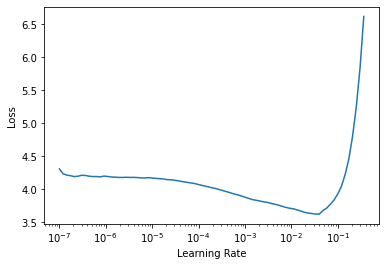

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.171875,3.835563,0.311599,46.319508,00:04
1,3.894583,3.488459,0.364784,32.735466,00:04
2,3.759853,3.456904,0.360126,31.718636,00:04
3,3.637913,3.214082,0.397837,24.880453,00:04
4,3.500756,3.112519,0.405950,22.477600,00:04
5,3.383809,3.049775,0.411358,21.110596,00:04
6,3.278821,2.995491,0.425481,19.995171,00:04
7,3.183629,2.957515,0.432993,19.250086,00:04
8,3.098630,2.937519,0.434495,18.868971,00:04
9,3.019623,2.911450,0.438101,18.383434,00:04


In [ ]:
learn.save_encoder('finetuned')

# 3. Classifier

The process for creating a text classifier is very similar to what we have followed to create a language model.

First we have to load the data. We do this in the following way.




In [ ]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path, path=path, bs=128, seq_len=72)

We can see one of the batches that is generated with the previous `DataBlock` as follows.

In [ ]:
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos xxup this xxup facsimile xxup transmission xxup is xxup intended xxup only xxup for xxup the xxup addressee xxup shown xxup below . xxup it xxup may xxup contain xxup information xxup that xxup is xxup privileged , xxup confidential xxup or xxup other xxup xxunk xxup protected xxup from xxup disclosure . xxup any xxup review , xxup dissemination xxup or xxup use xxup of xxup this xxup transmission xxup or xxup its xxup xxunk xxup by xxup persons xxup other xxup than xxup the xxup addressee xxup is xxup strictly xxup prohibited . xxup of xxup you xxup have xxup received xxup this xxup transmission xxup in xxup error , xxup please xxup notify xxup immediately xxup by xxup xxunk xxup and xxup mail xxup the xxup original xxup to xxup us xxup at xxup the xxup above xxup address .",other
1,"xxbos xxmaj the xxmaj cigarette xxmaj test xxmaj station ( xxunk ) xxunk xxunk of the xxunk xxunk xxunk that xxup r&d currently xxunk to xxunk cigarette weight , pressure drop , ventilation , and xxunk into one xxunk xxunk . xxmaj the xxup xxunk has the additional xxunk of cigarette xxunk in xxunk with the xxup xxunk . xxmaj with this added , xxunk xxup r&d will be xxunk to xxunk the xxmaj firmness xxmaj xxunk that xxunk cigarette firmness in addition to other xxunk that are xxunk above . xxmaj the xxmaj firmness xxmaj xxunk is no xxunk xxunk and parts are xxunk difficult to obtain . xxmaj xxunk , purchase of this xxunk would provide xxunk xxunk as the xxmaj macon xxmaj plant and xxunk xxunk xxunk between laboratories .",answer
2,"xxbos xxmaj this is your authorization to provide the "" xxunk : xxmaj the xxmaj effect of xxmaj inhalation of xxmaj reference and xxmaj test ( xxunk and xxup xxunk ) xxmaj cigarette xxmaj smoke on xxmaj two xxmaj xxunk xxmaj xxunk in xxmaj mice : xxmaj chromosome xxmaj xxunk and xxmaj xxunk xxmaj xxunk xxmaj xxunk "" test for a fixed price of $ xxunk xxmaj tests will be performed in accordance with the xxmaj december 21 , 1981 formal agreement between xxmaj xxunk xxmaj associates and xxmaj lorillard . xxmaj all work is to be coordinated with our xxmaj dr . xxmaj xxunk xxmaj minnemeyer ( 919 ) 373 - xxunk",answer



Now we move on to building our `Learner` in a similar way as we did previously.

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

Before starting to train it, we must load the *encoder* that we saved previously.

In [ ]:
learn = learn.load_encoder('finetuned')

We look for the best learning rate

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0014454397605732083)

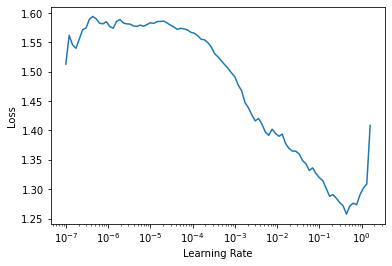

In [ ]:
learn.lr_find()

Now we can train our classifier. We start by training only the last layer.

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.032125,0.815963,0.704545,00:09


Now we unfreeze two layers and look for the best learning rate.

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.5848931980144698e-06)

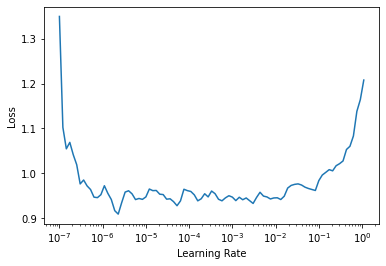

In [ ]:
learn.freeze_to(-2)
learn.lr_find()

We train the model

In [ ]:
learn.fit_one_cycle(1,1.1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.919190,0.818250,0.695969,00:09


We can unfreeze a little more and keep training.

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=4.786300905834651e-06)

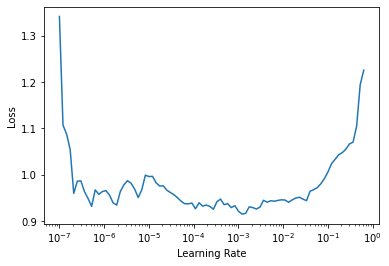

In [ ]:
learn.freeze_to(-3)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.885750,0.741213,0.708405,00:09
1,0.789678,0.676745,0.743568,00:09


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=7.585775847473997e-07)

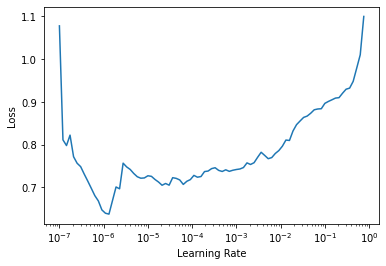

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.719450,0.667304,0.750000,00:09
1,0.710317,0.638344,0.742710,00:09
2,0.696274,0.645830,0.746141,00:09
3,0.680779,0.636887,0.748285,00:09
4,0.665798,0.649298,0.744854,00:09


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

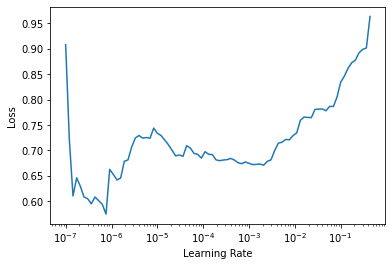

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.666547,0.638832,0.741424,00:09
1,0.662995,0.639506,0.740995,00:09
2,0.641625,0.644090,0.740137,00:09
3,0.627933,0.631821,0.746141,00:09
4,0.611537,0.651725,0.749142,00:09


SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=6.309573450380412e-07)

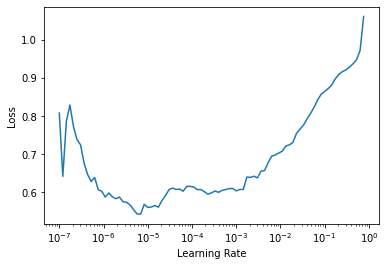

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.607697,0.664750,0.748285,00:09
1,0.610866,0.644024,0.749571,00:09
2,0.607385,0.647009,0.753859,00:09
3,0.576887,0.614648,0.764151,00:09
4,0.570757,0.642364,0.761149,00:09


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=1.9054607491852948e-06)

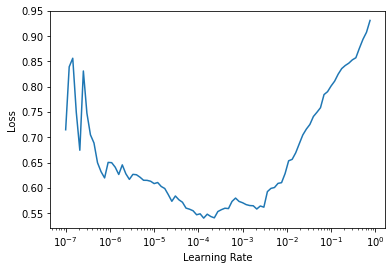

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.544223,0.656002,0.757290,00:09
1,0.538840,0.625375,0.749571,00:09
2,0.551392,0.654698,0.753431,00:09
3,0.528662,0.642721,0.757719,00:09
4,0.526063,0.655072,0.756432,00:09


# Results

In [ ]:
from fastai import *
from fastai.text import *
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

We get the predictions and the ground truth

In [ ]:
pred,gtruth=learn.get_preds()
pred=np.argmax(pred,axis=1)

**Accuracy:** 

In [ ]:
accuracy_score(pred,gtruth)

0.7564322469982847

**Precision:**

In [ ]:
precision_score(pred,gtruth, average='weighted')

0.7697468115625257

**Recall**

In [ ]:
recall_score(pred,gtruth, average='weighted')

0.7564322469982847

**F1-Score:**

In [ ]:
f1_score(pred,gtruth, average='weighted')

0.7610866145176408